In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
from data import stock_data
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

In [4]:
con = sqlite3.connect("stock_data.db", check_same_thread=False)

In [5]:
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", con)
print(tables)

    name
0    IBM
1   TSLA
2   NVDA
3    JPM
4    BTC
5    ETH
6   AAPL
7    SPY
8   INTC
9    AMC
10  COIN
11  MSFT
12   JNJ
13    PG


In [6]:
high_volatility_stocks = ['TSLA','NVDA', 'AMC', 'COIN']
stable_stocks=['AAPL','MSFT','JNJ','PG']

In [7]:
list(tables['name'])

['IBM',
 'TSLA',
 'NVDA',
 'JPM',
 'BTC',
 'ETH',
 'AAPL',
 'SPY',
 'INTC',
 'AMC',
 'COIN',
 'MSFT',
 'JNJ',
 'PG']

In [8]:
for stock in high_volatility_stocks:
    if stock not in tables['name'].values:
        dt=stock_data(stock)
        dt.get_daily('full')
        dt.insert_table(con,if_exists='replace')

In [9]:
for stock in stable_stocks:
    if stock not in tables['name'].values:
        dt=stock_data(stock)
        dt.get_daily('full')
        dt.insert_table(con,if_exists='replace')

In [10]:
def get_stock_data(stock_list):
    df_dict = {}
    for stock in stock_list:
        df = pd.read_sql(f"SELECT * FROM {stock}", con, parse_dates=['date'], index_col='date')
        df.index = pd.to_datetime(df.index, format='ISO8601')
        df.sort_index(inplace=True)
        df_dict[stock] = df
        df_dict[stock]['returns'] = np.log(df['close'] / df['close'].shift(1)) * 100
        df_dict[stock].dropna(inplace=True)
    return df_dict

In [11]:
def plot_stock_data(df,feature='close'):
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    for i, stock in enumerate(df):
        df[stock][feature].plot(ax=ax[i//2, i%2], title=stock)
        ax[i//2, i%2].set_xlabel('Date')
        ax[i//2, i%2].set_ylabel(feature.capitalize())
        ax[i//2, i%2].grid(True)
    plt.tight_layout()
    plt.show()

In [43]:
def plot_stock_acf(df, lags=20):
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    for i, stock in enumerate(df):
        plot_acf(df[stock]['returns']**2, lags=lags, ax=ax[i//2, i%2], title=f'ACF for {stock}')
        ax[i//2, i%2].set_title(f'ACF for {stock}')
        ax[i//2, i%2].set_xlabel('Lags')
        ax[i//2, i%2].set_ylabel('ACF')
        ax[i//2, i%2].grid(True)
    plt.tight_layout()
    plt.show()

# Preliminary analysis of volatile stocks

In [13]:
df_volatile = get_stock_data(high_volatility_stocks)

In [14]:
df_volatile['TSLA']

,open,high,low,close,volume,returns
date,,,,,,
2010-06-30,25.790,30.4192,23.3000,23.83,17187100.0,-0.251467
2010-07-01,25.000,25.9200,20.2700,21.96,8218800.0,-8.172267
2010-07-02,23.000,23.1000,18.7100,19.20,5139800.0,-13.431234
2010-07-06,20.000,20.0000,15.8300,16.11,6866900.0,-17.547008
2010-07-07,16.400,16.6300,14.9800,15.80,6921700.0,-1.943026
...,...,...,...,...,...,...
2024-11-22,341.085,361.5300,337.7000,352.56,89140722.0,3.733459
2024-11-25,360.140,361.9300,338.2000,338.59,95890899.0,-4.043088
2024-11-26,341.000,346.9600,335.6600,338.23,62295857.0,-0.106380


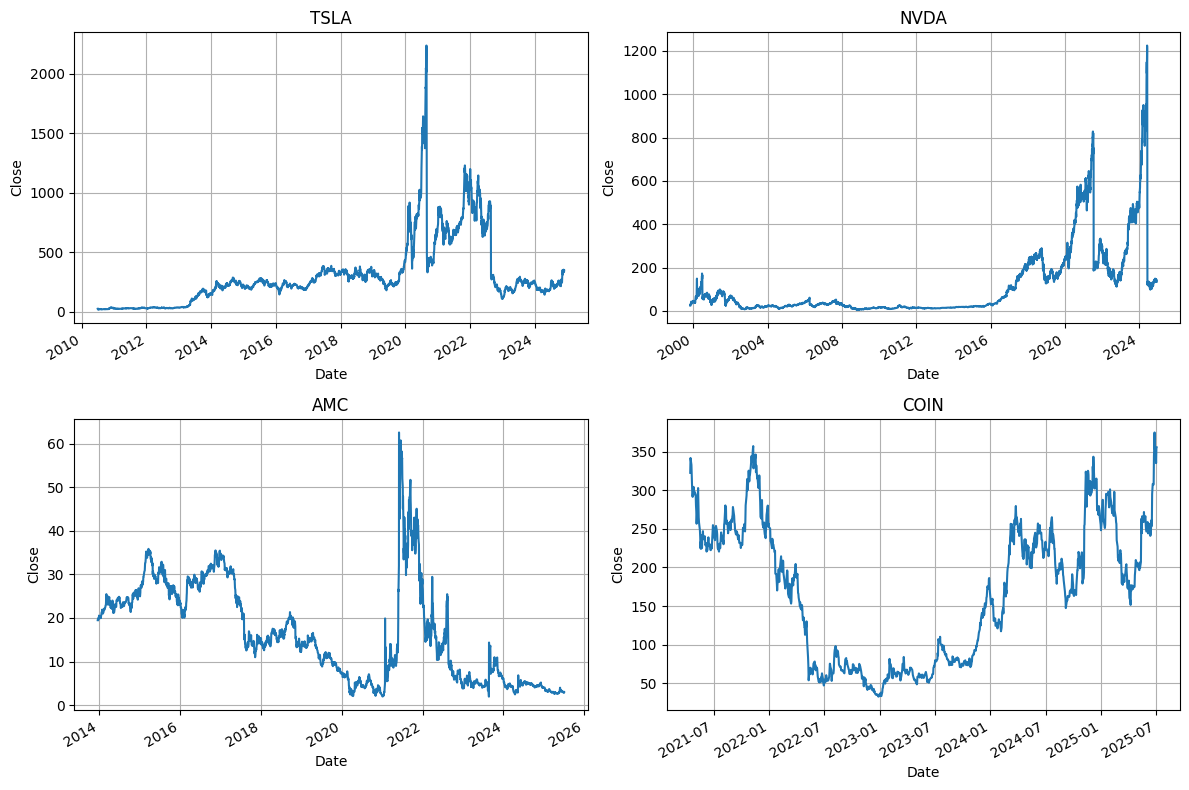

In [15]:
plot_stock_data(df_volatile, feature='close')

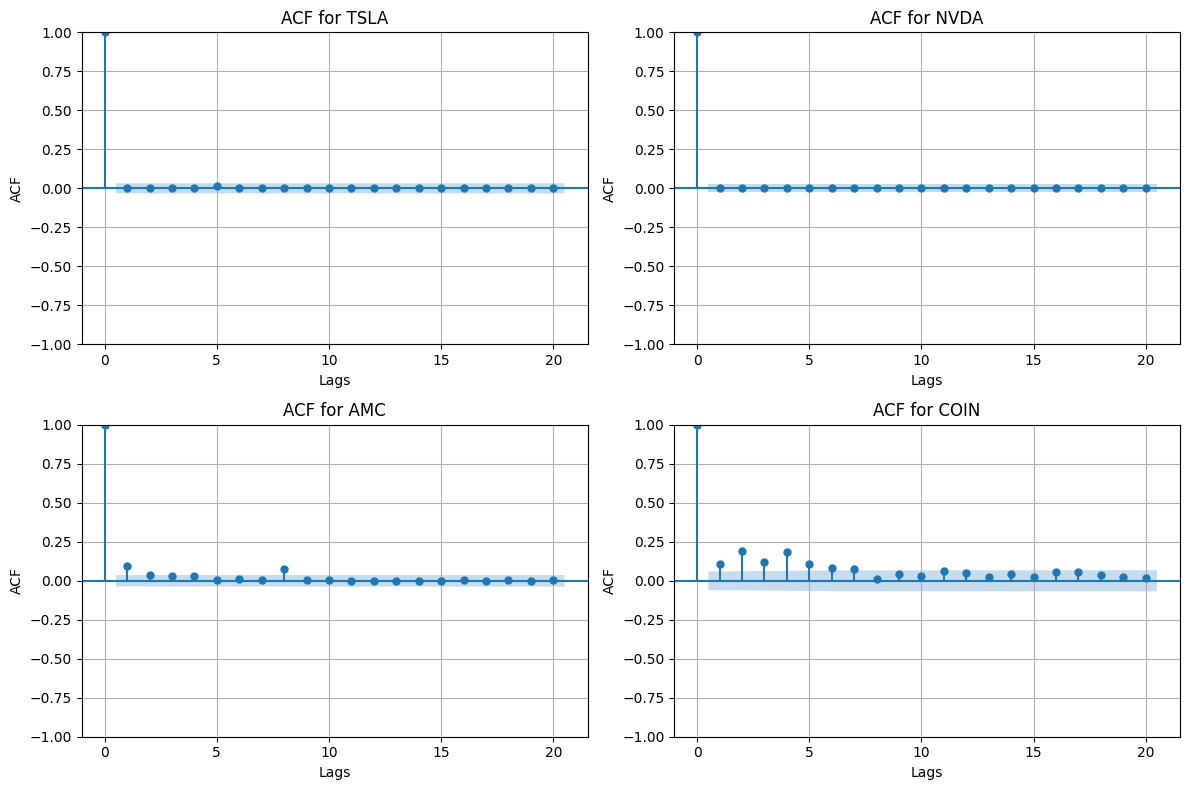

In [44]:
plot_stock_acf(df_volatile, lags=20)

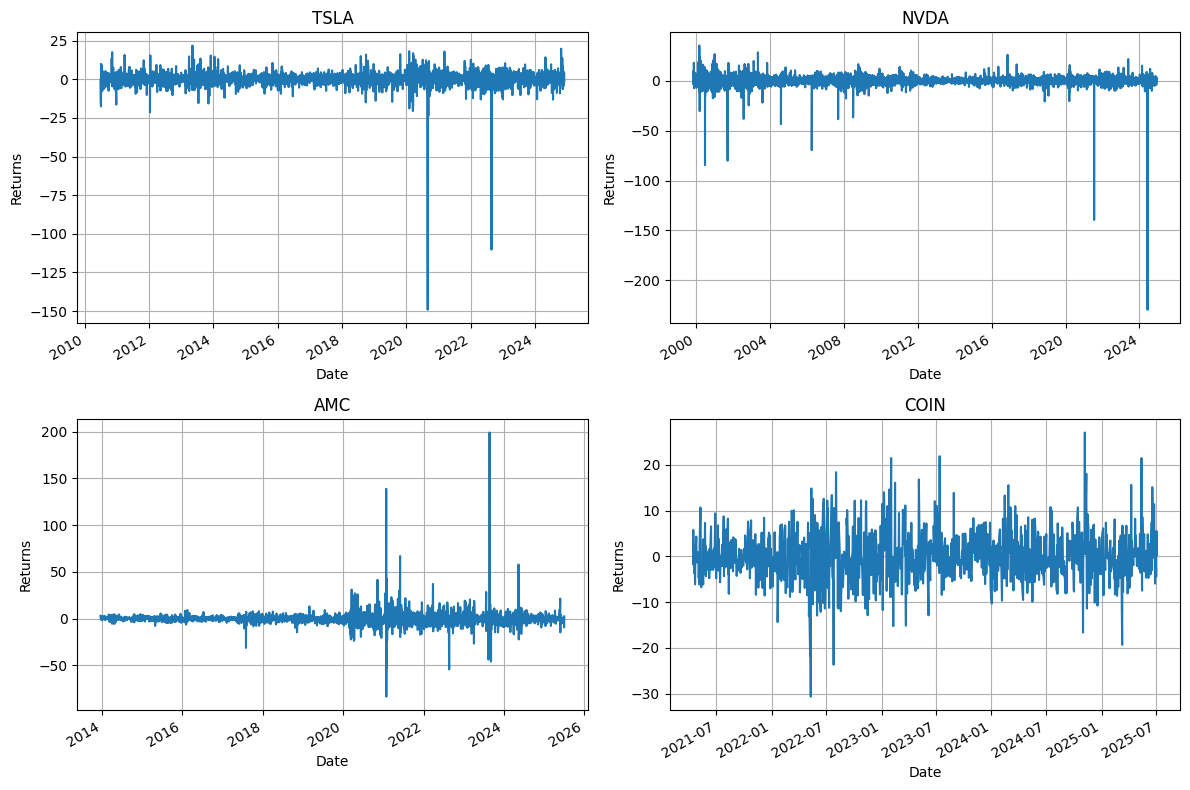

In [17]:
plot_stock_data(df_volatile, feature='returns')

# Preliminary analysis for stable stocks

In [46]:
df_stable = get_stock_data(stable_stocks)

In [47]:
df_stable['AAPL']

,open,high,low,close,volume,returns
date,,,,,,
1999-11-02,78.000,81.69,77.31,80.25,3564600.0,3.332164
1999-11-03,81.620,83.25,81.00,81.50,2932700.0,1.545626
1999-11-04,82.060,85.37,80.62,83.62,3384700.0,2.567971
1999-11-05,84.620,88.37,84.00,88.31,3721500.0,5.457063
1999-11-08,87.750,97.73,86.75,96.37,8490400.0,8.734160
...,...,...,...,...,...,...
2024-12-04,242.870,244.11,241.25,243.01,44383935.0,0.148252
2024-12-05,243.990,244.54,242.13,243.04,40033878.0,0.012344
2024-12-06,242.905,244.63,242.08,242.84,36870619.0,-0.082325


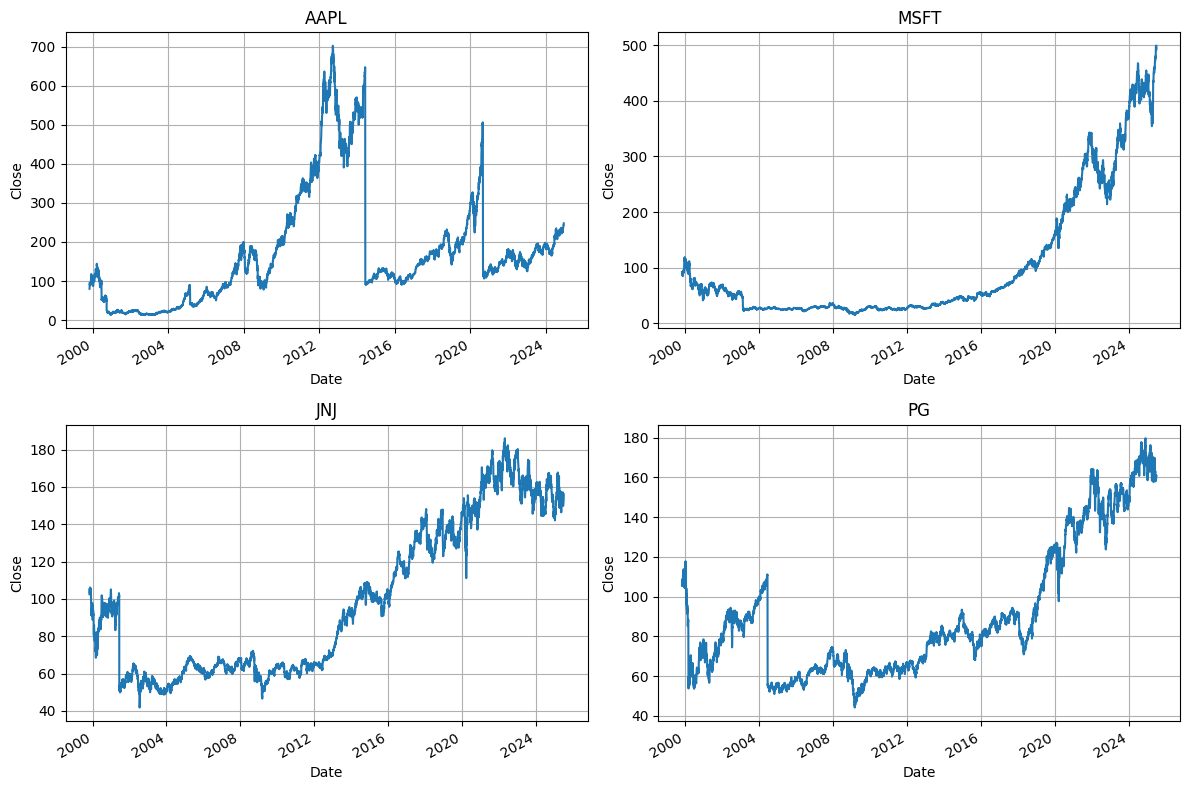

In [48]:
plot_stock_data(df_stable)

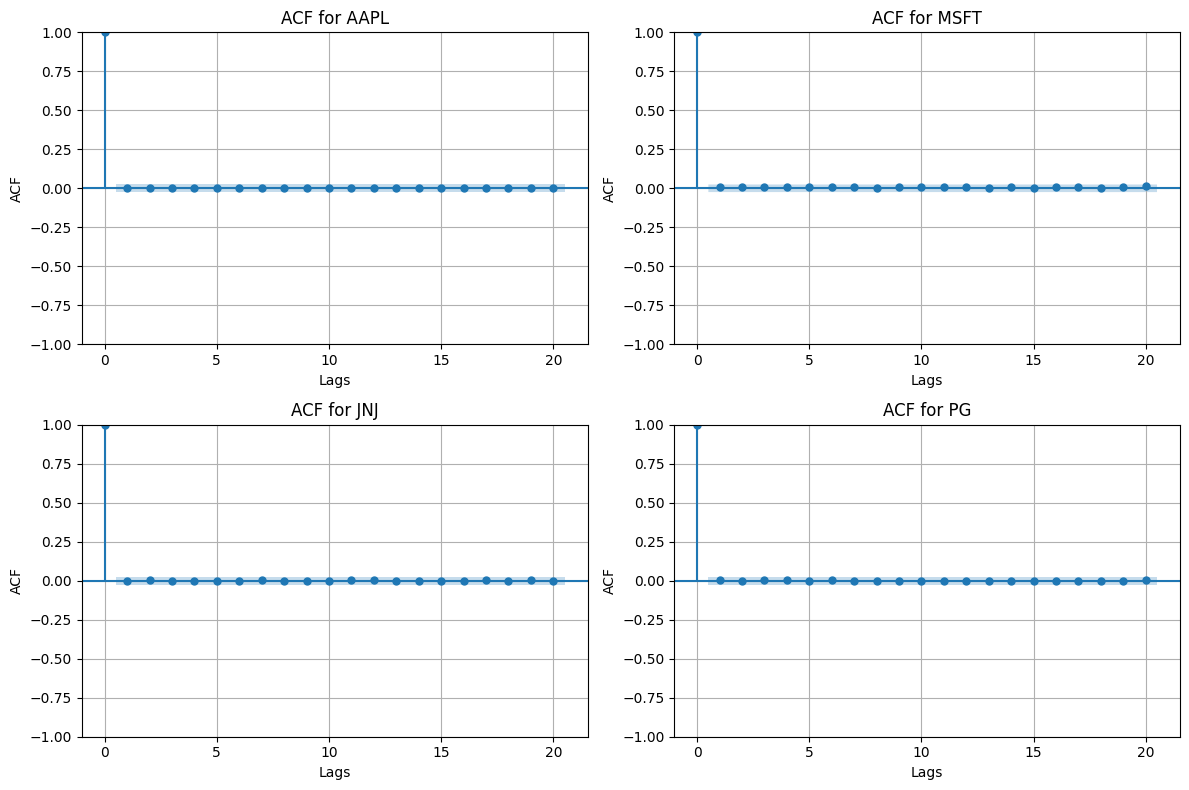

In [45]:
plot_stock_acf(df_stable, lags=20)

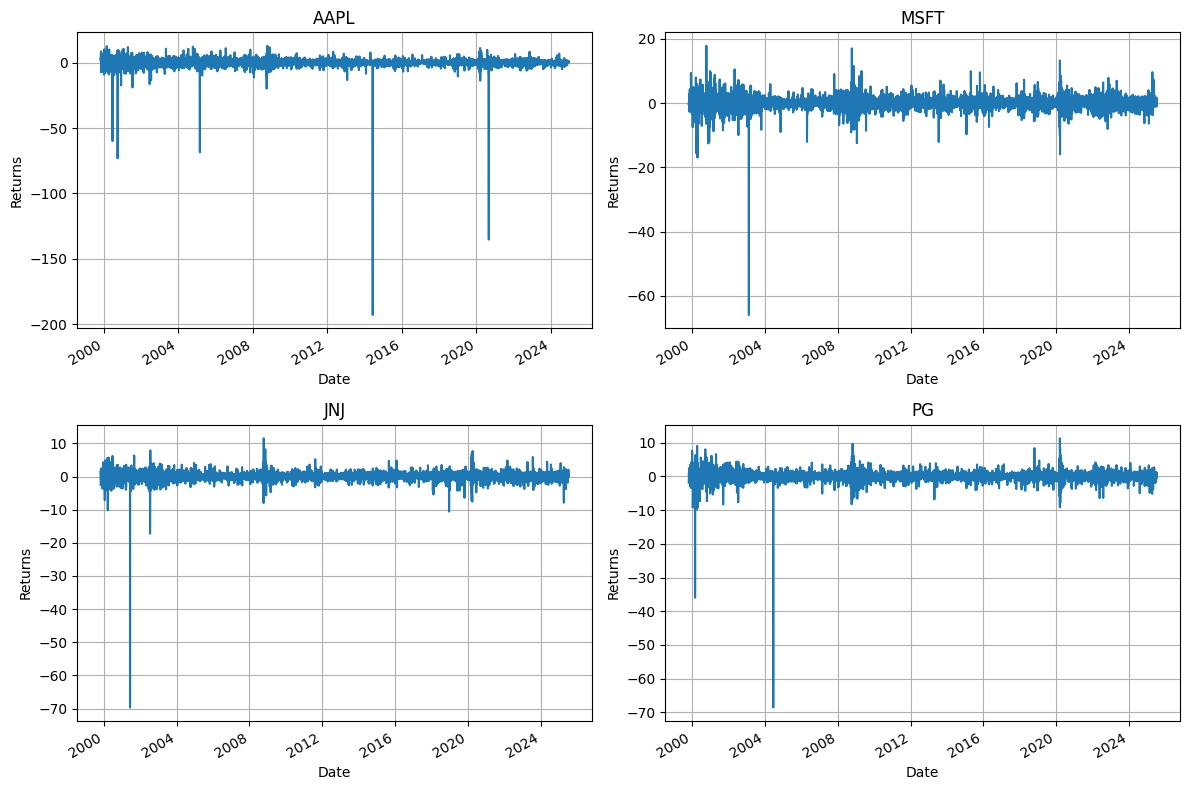

In [22]:
plot_stock_data(df_stable,feature='returns')

In [23]:
df_IBM = pd.read_sql("SELECT * FROM IBM", con, parse_dates=['date'], index_col='date')
df_IBM.index = pd.to_datetime(df_IBM.index, format='ISO8601')
df_IBM.sort_index(inplace=True)
df_IBM['returns'] = np.log(df_IBM['close'] / df_IBM['close'].shift(1)) * 100
df_IBM.dropna(inplace=True)

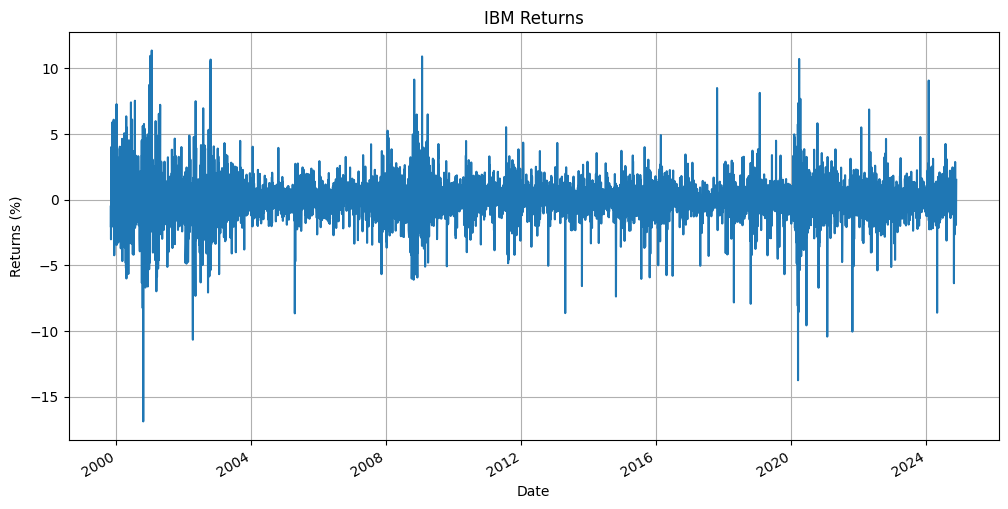

In [24]:
df_IBM['returns'].plot(figsize=(12, 6), title='IBM Returns')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.grid(True)
plt.show()

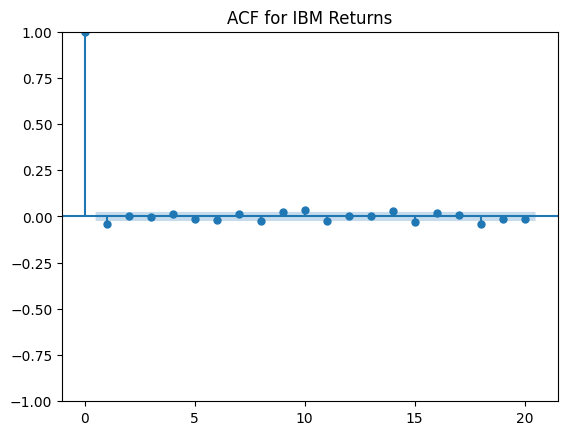

In [53]:
plot_acf(df_IBM['returns'], lags=20, title='ACF for IBM Returns')
plt.show()

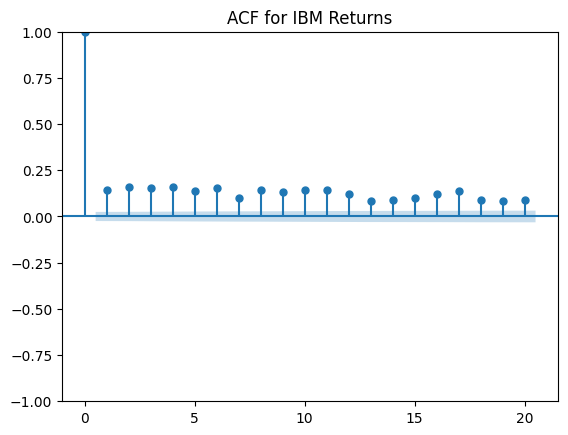

In [50]:
plot_acf(df_IBM['returns']**2, lags=20, title='ACF for IBM Returns')
plt.show()

In [54]:
df_INTC = pd.read_sql("SELECT * FROM INTC", con, parse_dates=['date'], index_col='date')
df_INTC.index = pd.to_datetime(df_INTC.index, format='ISO8601')
df_INTC.sort_index(inplace=True)
df_INTC['returns'] = np.log(df_INTC['close'] / df_INTC['close'].shift(1)) * 100
df_INTC.dropna(inplace=True)

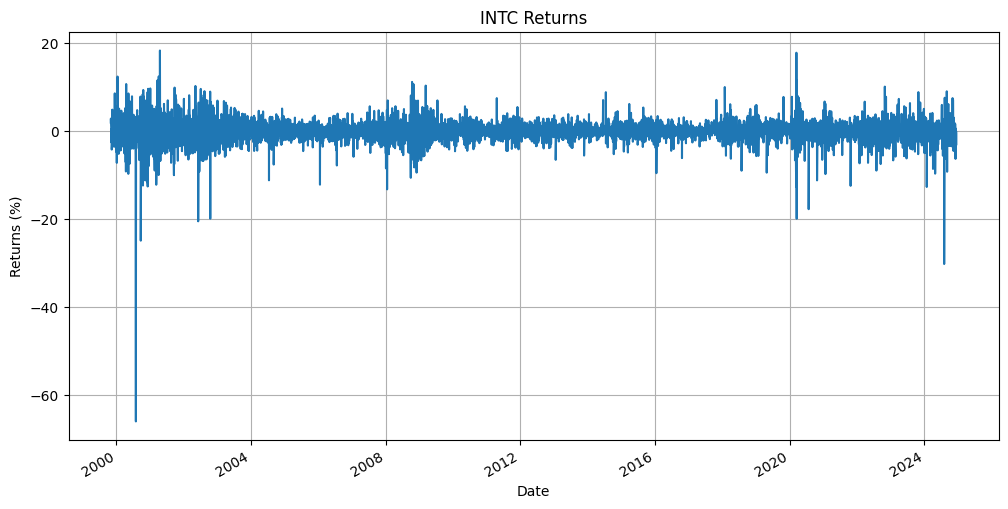

In [57]:
df_INTC['returns'].plot(figsize=(12, 6), title='INTC Returns')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.grid(True)
plt.show()

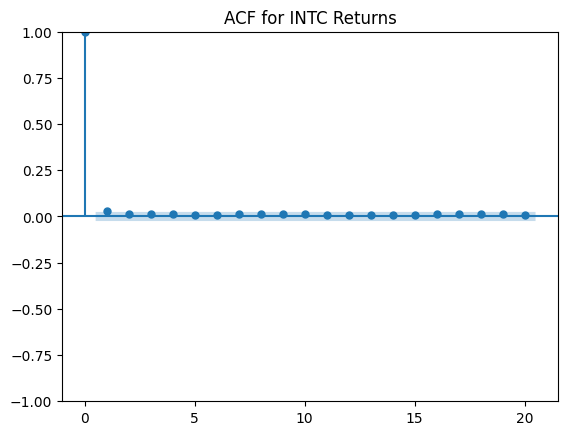

In [56]:
plot_acf(df_INTC['returns']**2, lags=20, title='ACF for INTC Returns')
plt.show()

In [58]:
df_JPM= pd.read_sql("SELECT * FROM JPM", con, parse_dates=['date'], index_col='date')
df_JPM.index = pd.to_datetime(df_JPM.index, format='ISO8601')
df_JPM.sort_index(inplace=True)
df_JPM['returns'] = np.log(df_JPM['close'] / df_JPM ['close'].shift(1)) * 100
df_JPM.dropna(inplace=True)     

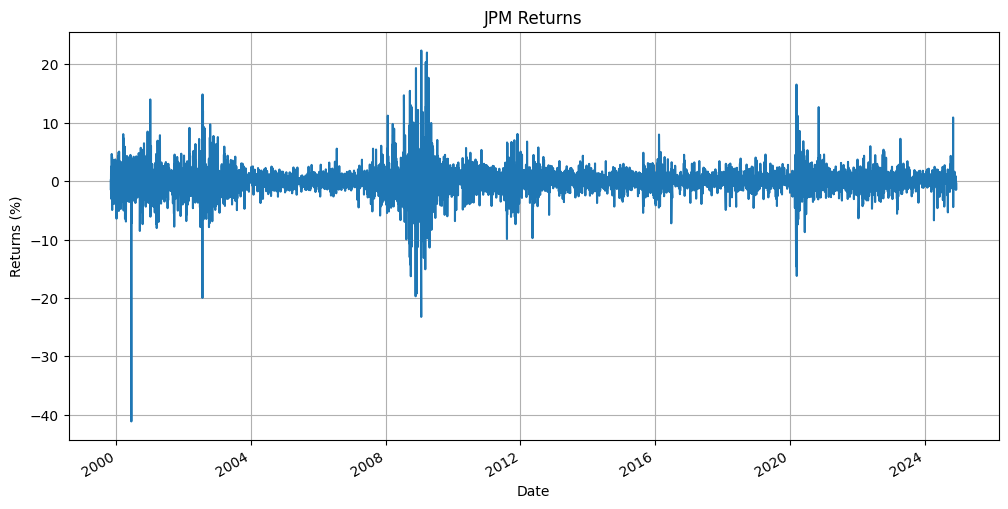

In [59]:
df_JPM['returns'].plot(figsize=(12, 6), title='JPM Returns')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.grid(True)
plt.show()

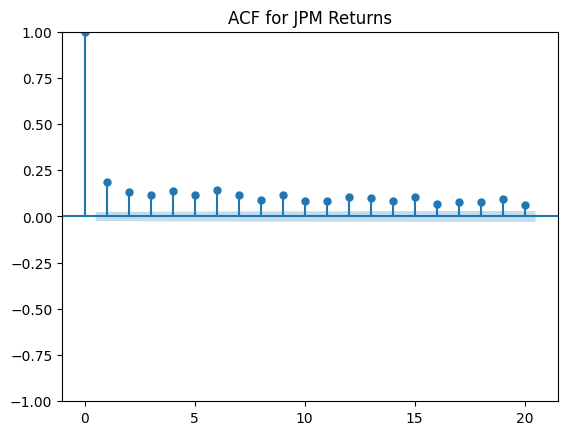

In [61]:
plot_acf(df_JPM['returns']**2, lags=20, title='ACF for JPM Returns')
plt.show()

In [36]:
df_IBM['returns']**2

date
1999-11-02     4.102830
1999-11-03     0.216380
1999-11-04     9.137762
1999-11-05     2.076740
1999-11-08    16.058200
                ...    
2024-11-12     1.630791
2024-11-13     0.000809
2024-11-14     0.845023
2024-11-15     3.734636
2024-11-18     2.252845
Name: returns, Length: 6302, dtype: float64

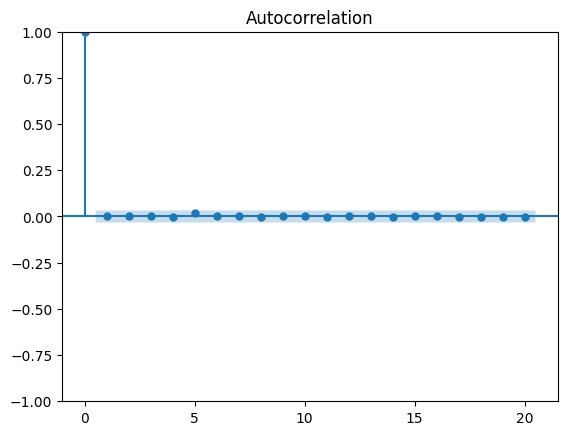

In [51]:
plot_acf(df_volatile['TSLA']['returns']**2, lags=20)
plt.show()

# GARCH walk forward

In [161]:
class GARCHWalkForward:
    def __init__(self, stock_data, train_size=0.8):
        self.stock_data = stock_data
        self.train_size = train_size

    def train_test_split(self):
        cutoff = int(len(self.stock_data) * self.train_size)
        y_test = self.stock_data["returns"].iloc[cutoff:]
        return y_test
    
    def fit_garch(self):
        y_test = self.train_test_split()
        w_fwd_pred =[]
        for i in range(len(y_test)):
            y_train = self.stock_data["returns"].iloc[1:-(len(y_test)-i)]
            model = arch_model(y_train, vol='EGARCH', p=1, q=1, rescale=False)
            res= model.fit(disp=0)
            forecasts = res.forecast(horizon=1)
            pred_vol = (forecasts.variance.values[-1,:][0])**0.5
            w_fwd_pred.append(pred_vol)
        return w_fwd_pred
    
    def plot_results(self,  w_fwd_pred):
        y_test = self.train_test_split()
        w_fwd_vol= pd.Series(w_fwd_pred, index=y_test.index, name='Predicted Volatility')
        test_vol= self.stock_data['returns'].rolling(window=21).std().dropna()
        test_vol=test_vol.iloc[-len(y_test):]
        plt.figure(figsize=(12, 6))
        plt.plot(y_test.index, y_test, color='lightgray', label='Log Returns')
        plt.plot(y_test.index, w_fwd_vol, color='black', label='Predicted Volatility')
        plt.plot(test_vol.index, test_vol, color='red', label='Actual Volatility')
        plt.legend()
        plt.title('GARCH Model Walk Forward Prediction')
        plt.xlabel('Date')
        plt.ylabel('Volatility')
        plt.show()

    def evaluate_model(self, w_fwd_pred):
        y_test = self.train_test_split()
        w_fwd_vol = pd.Series(w_fwd_pred, index=y_test.index, name='Predicted Volatility')
        test_vol = self.stock_data['returns'].rolling(window=21).std().dropna()
        test_vol = test_vol.iloc[-len(y_test):]
        
        r2 = r2_score(test_vol, w_fwd_vol)
        mae = mean_absolute_error(test_vol, w_fwd_vol)
        mse = mean_squared_error(test_vol, w_fwd_vol)
        
        print(f"R^2: {r2:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}")


In [162]:
garch_AAPL = GARCHWalkForward(df_stable['AAPL'])
AAPL_pred=garch_AAPL.fit_garch()

In [165]:
AAPL_pred

[np.float64(3.9316118733325505),
 np.float64(3.9476342329985634),
 np.float64(3.9436705264745915),
 np.float64(3.950569757819367),
 np.float64(3.963810278706741),
 np.float64(3.965579864515049),
 np.float64(3.9521625792875197),
 np.float64(3.9462459335433047),
 np.float64(3.931200050480194),
 np.float64(3.938452800388871),
 np.float64(3.950105403760196),
 np.float64(3.932882223945595),
 np.float64(3.920449308085687),
 np.float64(3.9078023981135157),
 np.float64(3.9000192373804334),
 np.float64(3.918307834617465),
 np.float64(3.9056508287692258),
 np.float64(3.9286846878740516),
 np.float64(3.9129315440852417),
 np.float64(3.9098402383693363),
 np.float64(3.9097136904737164),
 np.float64(3.9367480778116497),
 np.float64(3.9353396443844666),
 np.float64(3.930537820282632),
 np.float64(3.9213698355078934),
 np.float64(3.9336968949554394),
 np.float64(3.9522822898421865),
 np.float64(3.9332872833311057),
 np.float64(3.9520280249300366),
 np.float64(3.953494883525609),
 np.float64(3.9380134

In [164]:
garch_AAPL.evaluate_model(AAPL_pred)

R^2: -0.2418, MAE: 2.8296, MSE: 16.6632


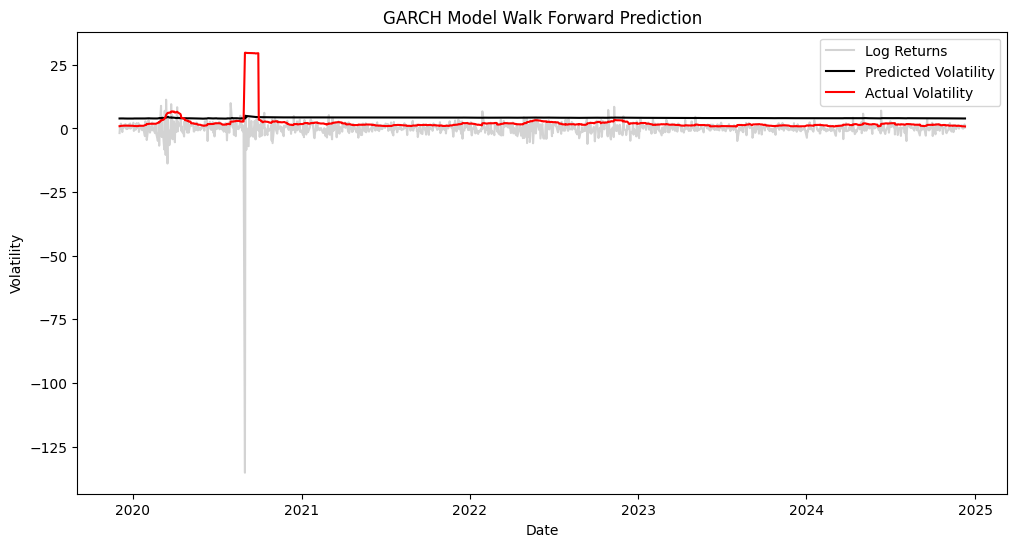

In [163]:
garch_AAPL.plot_results(AAPL_pred)

In [127]:
garch_MSFT = GARCHWalkForward(df_stable['MSFT'])
MSFT_pred=garch_MSFT.fit_garch()
garch_MSFT.evaluate_model(MSFT_pred)


R^2: 0.7357, MAE: 0.2315, MSE: 0.0764


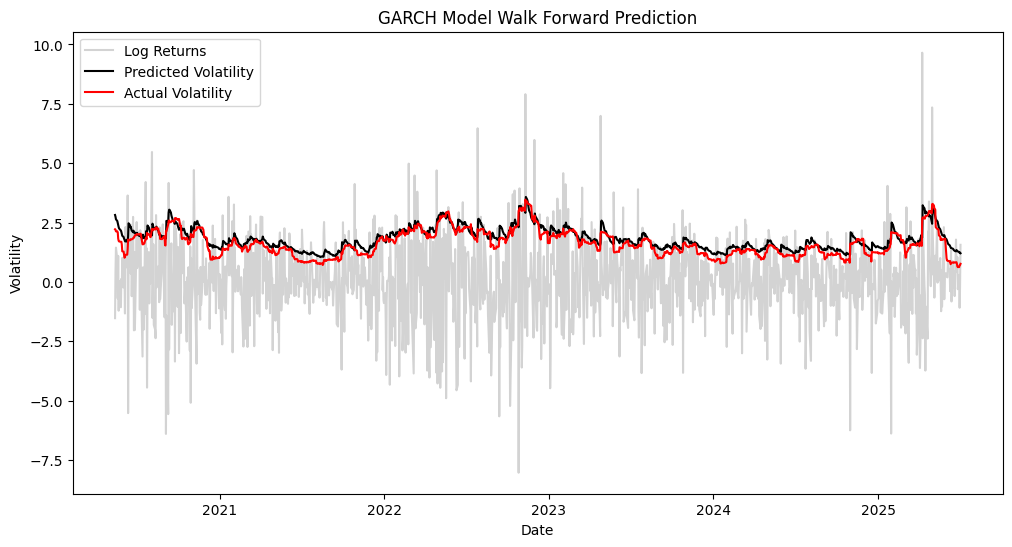

In [128]:
garch_MSFT.plot_results(MSFT_pred)

In [ ]:
garch_JNJ = GARCHWalkForward(df_stable['JNJ'])
JNJ_pred=garch_JNJ.fit_garch()

/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projec

R^2: -0.9725, MAE: 0.3228, MSE: 0.1735


/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


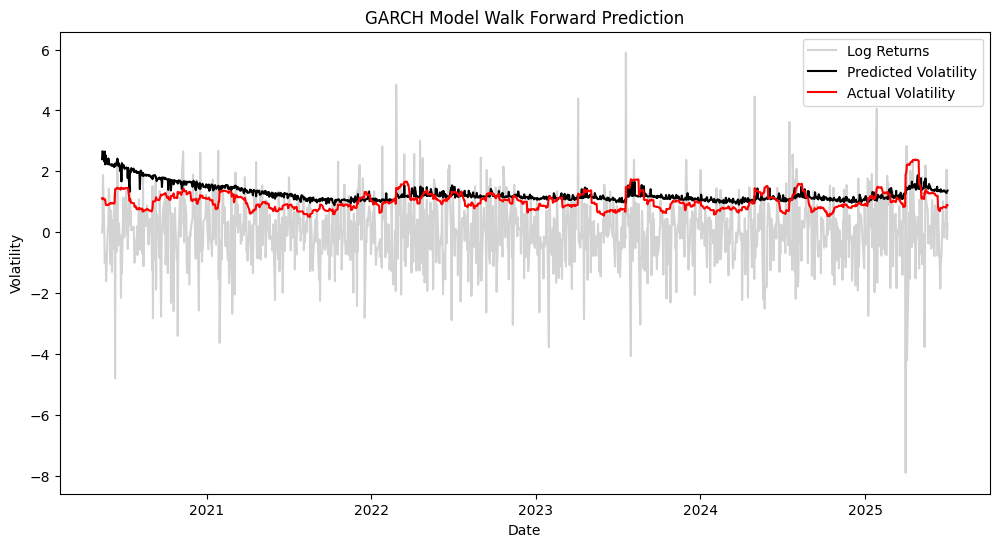

In [122]:
garch_JNJ.plot_results(JNJ_pred)

In [130]:
garch_JNJ.evaluate_model(JNJ_pred)

R^2: -0.9725, MAE: 0.3228, MSE: 0.1735


/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projec

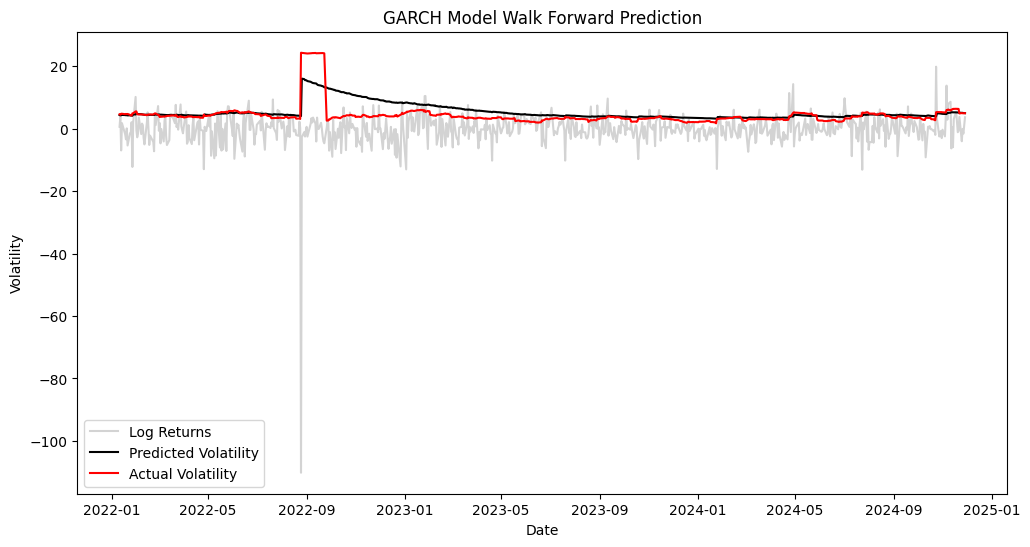

In [131]:
garch_TSLA = GARCHWalkForward(df_volatile['TSLA'])
TSLA_pred=garch_TSLA.fit_garch()
garch_TSLA.plot_results(TSLA_pred)

In [132]:
garch_TSLA.evaluate_model(TSLA_pred)

R^2: 0.3255, MAE: 1.7266, MSE: 8.5075


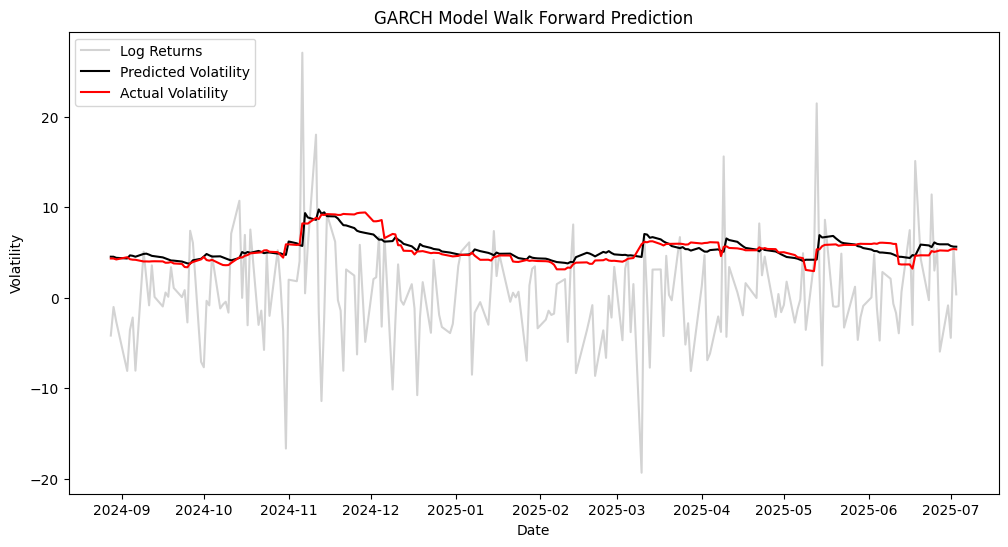

In [133]:
garch_COIN = GARCHWalkForward(df_volatile['COIN'])
COIN_pred=garch_COIN.fit_garch()
garch_COIN.plot_results(COIN_pred)

In [134]:
garch_COIN.evaluate_model(COIN_pred)

R^2: 0.7507, MAE: 0.5885, MSE: 0.5485


In [135]:
df_volatile['COIN'].shape

(1060, 6)

In [136]:
df_volatile['TSLA'].shape

(3630, 6)

In [138]:
df_volatile['COIN']

,open,high,low,close,volume,returns
date,,,,,,
2021-04-15,348.900,349.2000,317.2701,322.75,39777858.0,-1.698887
2021-04-16,327.500,345.9900,321.0300,342.00,22654542.0,5.793271
2021-04-19,337.260,341.0100,326.7900,333.00,11405556.0,-2.666825
2021-04-20,333.425,334.8300,312.0201,320.82,18082257.0,-3.726227
2021-04-21,312.520,327.4700,302.1000,311.92,10103896.0,-2.813347
...,...,...,...,...,...,...
2025-06-27,369.540,372.5000,346.6600,353.43,29000430.0,-5.942723
2025-06-30,359.225,360.4500,347.9000,350.49,11227558.0,-0.835327
2025-07-01,339.980,353.3956,334.0000,335.33,13132139.0,-4.421705
